# Inflation

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Read Data

In [40]:
inflation: pd.DataFrame = pd.read_csv("data/inflation.csv", skiprows=[0, 1, 2, 3], index_col=0).drop(["Country Code", "Indicator Name", "Indicator Code", "Unnamed: 65"], axis=1)
inflation.columns = inflation.columns.astype(int)
inflation = inflation.unstack().reorder_levels([1, 0]).sort_index()
inflation.index.set_names(["country_name", "year"], inplace=True)
inflation = inflation.to_frame("inflation_rate")
inflation.dropna()

inflation_rate
country_name year                
Afghanistan  2005       12.686269
             2006        6.784597
             2007        8.680571
             2008       26.418664
             2009       -6.811161
...                           ...
Zimbabwe     2014       -0.197785
             2015       -2.430968
             2016       -1.543670
             2017        0.893962
             2018       10.618866

[10262 rows x 1 columns]

In [11]:
avg_inf = inflation.loc[inflation.index.get_level_values(1) > 2010].copy()
avg_inf = avg_inf.groupby(avg_inf.index.get_level_values(0)).mean()
avg_inf

,inflation_rate
country_name,
Afghanistan,4.659091
Africa Eastern and Southern,6.111355
Africa Western and Central,2.415141
Albania,1.927873
Algeria,4.499698
...,...
West Bank and Gaza,1.118854
World,2.523479
"Yemen, Rep.",12.125529


# Read Democracy

In [12]:
dem: pd.DataFrame = pd.read_hdf("data/democracy.h5", "democracy")
dem_country = dem.groupby(dem.index.get_level_values(0)).mean()["score"]
dem_country

country_name
Afghanistan    0.244206
Albania        0.550606
Algeria        0.276217
Angola         0.240906
Argentina      0.713489
                 ...   
Venezuela      0.328346
Vietnam        0.220478
Yemen          0.184450
Zambia         0.499800
Zimbabwe       0.242433
Name: score, Length: 152, dtype: float64

## Create Linear Regression

/Users/micha/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


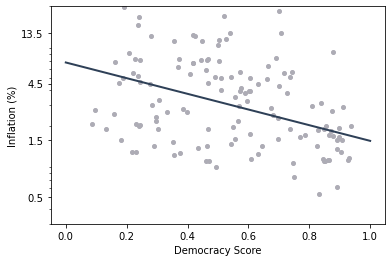

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         inflation_rate   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     24.22
Date:                Mon, 31 Jan 2022   Prob (F-statistic):           2.48e-06
Time:                        13:26:56   Log-Likelihood:                -171.30
No. Observations:                 136   AIC:                             346.6
Df Residuals:                     134   BIC:                             352.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9119      0.184     10.374      0.000       1.547       2.276
score         -1.5139      0.308     -4.922      0.000      -2.122      -0.906
==============================================================================
Omnibus:                        4.381   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.112   Jarque-Bera (JB):                4.286
Skew:                          -0.262   Prob(JB):                        0.117
Kurtosis:                       3.694   Cond. No.                         5.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
inf_dem = avg_inf.join(dem_country, how="inner").dropna()
model = sm.OLS(np.log(inf_dem["inflation_rate"]).replace({np.nan: 1}), sm.add_constant(inf_dem["score"]))
regr = model.fit()
plt.scatter(inf_dem["score"], inf_dem["inflation_rate"], 16, marker="o", color="#ADACB5")
x = np.linspace(0, 1)
plt.plot(x, np.exp(regr.predict(sm.add_constant(x))), linewidth=2, color="#2E4057")
plt.yscale("log")
plt.yticks([0.5, 1.5, 4.5, 12], ["0.5", "1.5", "4.5", "13.5"])
plt.ylim(0.3, 20)
plt.ylabel("Inflation (%)")
plt.xlabel("Democracy Score")
plt.show()
regr.summary()

## Inflation over time

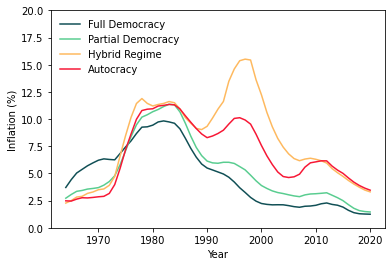

In [50]:
dem_raw = pd.read_hdf("data/democracy.h5", "democracy_raw")
inf_dem_total = inflation.join(dem_raw["v-dem-score"]).dropna()

bins = pd.cut(inf_dem_total["v-dem-score"], bins=[0, 0.4, 0.6, 0.8, 1])
inf_dem_total = inf_dem_total.groupby([bins, "year"]).median()["inflation_rate"].reorder_levels([1, 0]).sort_index().unstack()
inf_dem_total = inf_dem_total.ewm(span=5).mean().rolling(5).mean()
inf_dem_total = inf_dem_total.reindex(sorted(inf_dem_total.columns, reverse=True), axis=1)

colors = ["#104F55", "#59CD90", "#FEB95F", "#F71735"]
plt.gca().set_prop_cycle(color=colors)
plt.plot(inf_dem_total)
plt.legend(inf_dem_total.columns)
plt.xlabel("Year")
plt.ylabel("Inflation (%)")
plt.ylim(0, 20)
plt.legend(["Full Democracy", "Partial Democracy", "Hybrid Regime", "Autocracy"], frameon=False)
plt.show()